In [11]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from skimage import io
import torchvision.transforms as transforms
import torchvision.models.segmentation
import numpy as np

# LOAD LOCAL DATASET
- A specific class for the dataset is needed (with the following functions: init, len, get item)

- data must be located in "/content" folder in Google Colab

In [ ]:
#locate dataset
os.path.exists("/content/bt_d/bt90_2.jpg")
os.path.exists("/content/bt_dataset_new.csv")

False

In [ ]:
class BottleOrientationDataset(Dataset):
  def __init__(self,csv_file, root_dir,transform=None):
    self.annotations=pd.read_csv(csv_file)
    self.root_dir=root_dir
    self.transform=transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image=io.imread(img_path)
    y_label=torch.tensor(float(self.annotations.iloc[index,1]))
    if self.transform:
      image=self.transform(image)
    return (image,y_label)


In [ ]:
#data are located in content Colab folder
dataset=BottleOrientationDataset(csv_file="/content/bt_dataset.csv", root_dir="/content/bt_d", transform=transforms.ToTensor())

In [ ]:
print(dataset)
len(dataset)

6

In [ ]:
trainset,testset=torch.utils.data.random_split(dataset,[6,0])
train_loader=DataLoader(dataset=trainset, batch_size=1,shuffle=True)

print(train_loader)

tensor([0.2500])


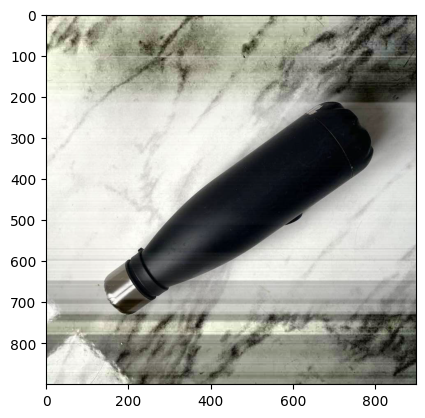

tensor([0.5000])


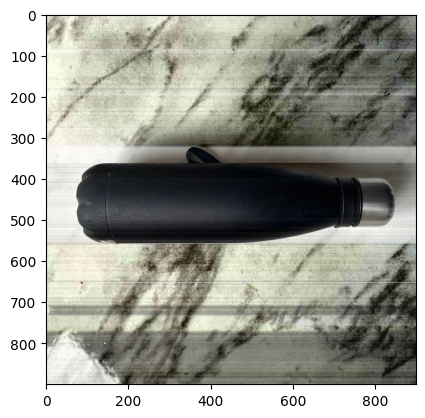

tensor([1.])


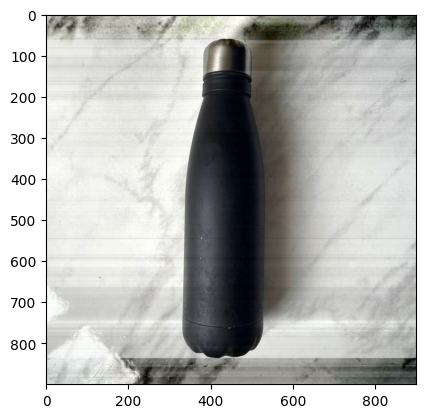

tensor([1.])


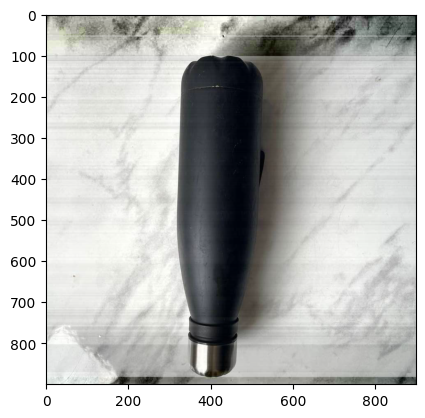

tensor([0.2500])


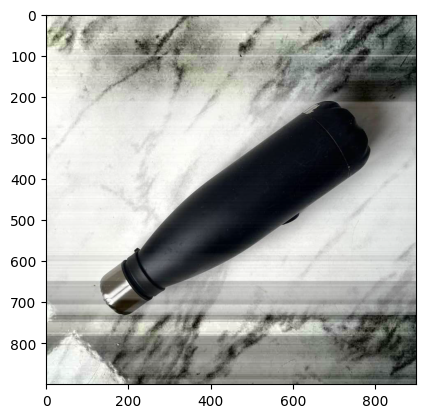

tensor([0.5000])


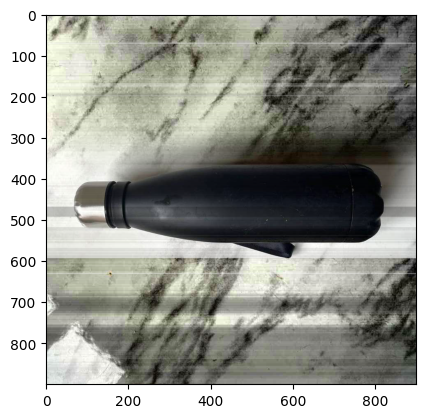

In [ ]:
#show data from data
from matplotlib import pyplot as plt
for batch in train_loader:
    inputs, targets = batch
    print(targets)
    for img in inputs:
        image  = img.cpu().numpy()
        # transpose image to fit plt input
        image = image.T
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        plt.show()

# TRAINING
- Performed through fine tuning of RESNET18
- Backpropagation used just in last layers.
- Model modified with just one neuron at the end, used to predict continuous values instead of classes.
- MSELoss (regression) instead of CrossEntropyLoss (classification).

In [ ]:
#gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Set device GPU or CPU where the training will take place

#pretrained model
model = torchvision.models.resnet18(pretrained=True)
print(model)

# for param in model.parameters():
#   param.requires_grad=False

# change final layer to predict one value
model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True) 
print(model)
model = model.to(device)

#config for training
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-4) # Create adam optimizer
import torch.nn as nn  
mse = nn.MSELoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(20):
  losses=[]
  performances=[]

  for batch_idx, (data, target) in enumerate(train_loader):
    data=data.to(device=device)
    target=target.to(device=device)

    print(target)
    result=model(data)
    print(result)

    loss=mse(result,target.unsqueeze(1))
    losses.append(loss.item())

    #performances.append(target.item()-result.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  print(sum(losses)/len(losses))
  #print(sum(performances)/len(performances))

print("Saving Model") #Save model weight
torch.save(model.state_dict(),   "hello" + ".torch")
print(losses)

tensor([1.])
tensor([[0.7973]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.8331]], grad_fn=<AddmmBackward0>)
tensor([0.2500])
tensor([[0.8371]], grad_fn=<AddmmBackward0>)
tensor([1.])
tensor([[0.7712]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.6973]], grad_fn=<AddmmBackward0>)
tensor([0.2500])
tensor([[0.6249]], grad_fn=<AddmmBackward0>)
0.12143461406230927
tensor([0.2500])
tensor([[0.2416]], grad_fn=<AddmmBackward0>)
tensor([1.])
tensor([[0.8409]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3427]], grad_fn=<AddmmBackward0>)
tensor([0.2500])
tensor([[0.1569]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.1660]], grad_fn=<AddmmBackward0>)
tensor([1.])
tensor([[0.7883]], grad_fn=<AddmmBackward0>)
0.035858838663746916
tensor([0.2500])
tensor([[0.2730]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.5455]], grad_fn=<AddmmBackward0>)
tensor([0.2500])
tensor([[0.3765]], grad_fn=<AddmmBackward0>)
tensor([1.])
tensor([[0.9829]], grad_fn=<Addm

In [ ]:
print(losses)

[0.0009660020587034523, 0.0001027157049975358, 0.001462905085645616, 0.001865139463916421, 0.0013178330846130848, 0.003134263912215829]


In [ ]:
def check_accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.train()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            print(y)
            print(scores)

check_accuracy(train_loader,model)

tensor([1.])
tensor([[0.9759]])
tensor([1.])
tensor([[0.8556]])
tensor([0.5000])
tensor([[0.4963]])
tensor([0.2500])
tensor([[0.2634]])
tensor([0.5000])
tensor([[0.4743]])
tensor([0.2500])
tensor([[0.2715]])


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")

plt.plot(losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# EVALUATION

In [ ]:
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'bt_dataset.csv', 'bt_d', '.ipynb_checkpoints', 'hello.torch', 'sample_data']


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.resnet18(pretrained=True) # Load net
model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True) # Set final layer to predict one value
model = model.to(device) # Assign net to gpu or cpu
#
model.load_state_dict(torch.load("hello.torch")) # Load trained model

<All keys matched successfully>

In [13]:
model.train() #?????

with torch.no_grad():
  for batch_idx, (data, target) in enumerate(train_loader):
    data=data.to(device=device)
    target=target.to(device=device)
    scores = model(data)
    print(target)
    print(scores)

tensor([0.5000])
tensor([[0.4743]])
tensor([1.])
tensor([[0.9759]])
tensor([0.2500])
tensor([[0.2634]])
tensor([0.5000])
tensor([[0.4963]])
tensor([0.2500])
tensor([[0.2715]])
tensor([1.])
tensor([[0.8556]])
